In [89]:
import json
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
from scipy.stats import pointbiserialr
import seaborn as sns
from sklearn.utils import resample

matplotlib.rcParams['font.family'] = 'Times New Roman'

In [79]:
imagenes = './images'
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()
    
data = json.loads(json_data)

In [80]:
anomalous_data = []  

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (x, y, w, h, anomalous) in bboxes:
        color = 'r' if anomalous else 'g' 
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

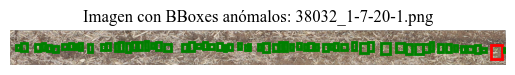

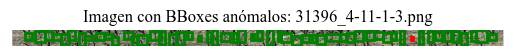

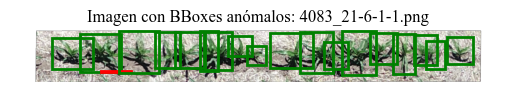

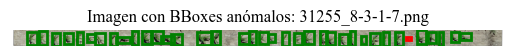

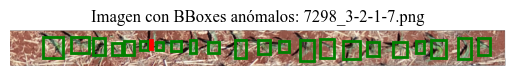

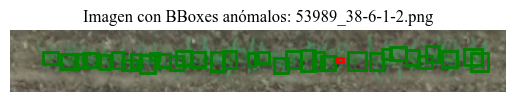

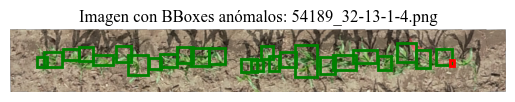

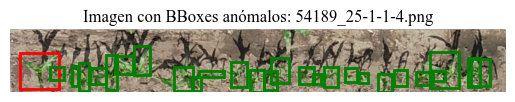

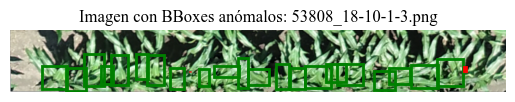

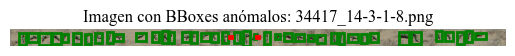

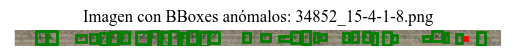

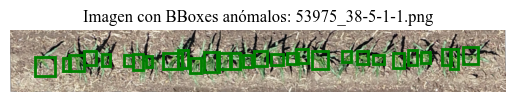

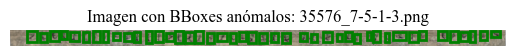

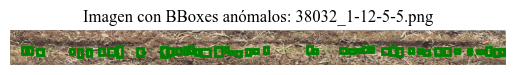

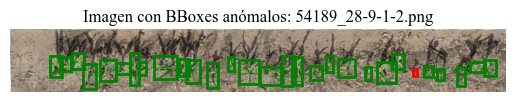

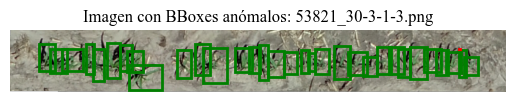

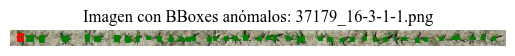

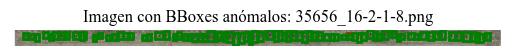

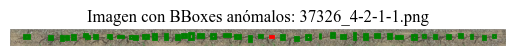

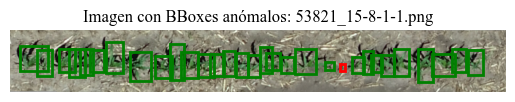

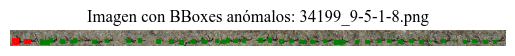

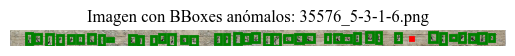

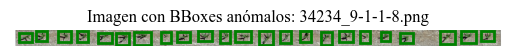

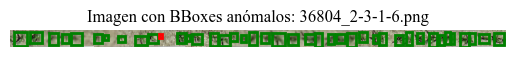

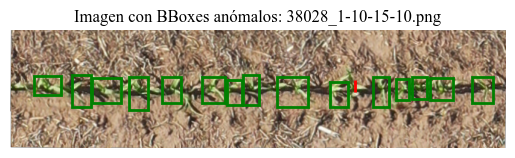

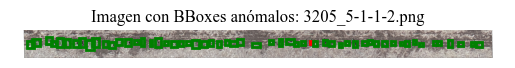

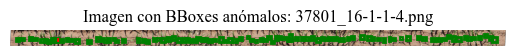

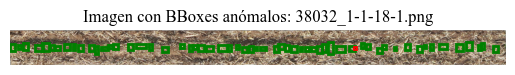

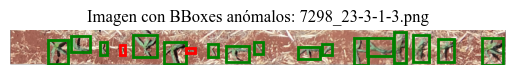

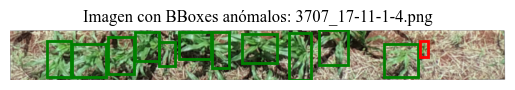

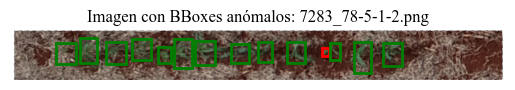

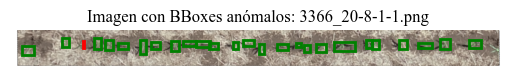

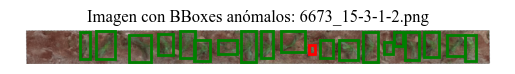

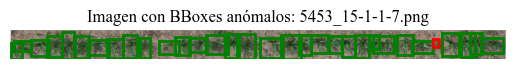

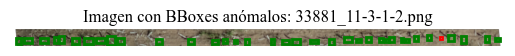

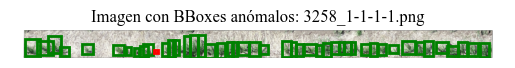

In [81]:
for item in data:
    annotations = item.get('annotations', [])
    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_name = item['item']['name']  

    areas = []
    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        area = w * h
        areas.append(area)
        bboxes_details.append((x, y, w, h))

    if areas:
        median_area = np.median(areas)
        threshold_upper = 5 * median_area
        threshold_lower = 0.15 * median_area

        annotated_bboxes = []
        show = False
        for (x, y, w, h), area in zip(bboxes_details, areas):
            anomalous = area > threshold_upper or area < threshold_lower
            annotated_bboxes.append((x, y, w, h, anomalous))
            if anomalous:
                anomalous_data.append({
                    'Image Name': image_name,
                    'X': x,
                    'Y': y,
                    'Width': w,
                    'Height': h,
                    'Anomalous Area': area,
                    'Median Area': median_area
                })
                show = True

        if show:
            show_image_with_boxes(image_url, annotated_bboxes, f"Imagen con BBoxes anómalos: {image_name}")

In [101]:
df_anomalous_images = pd.DataFrame(anomalous_data)
print(df_anomalous_images)

              Image Name        X       Y  Width  Height  Anomalous Area  \
0     38032_1-7-20-1.png  1970.02   58.94  43.93   59.05       2594.0665   
1     31396_4-11-1-3.png  1957.48   33.10  10.30   17.82        183.5460   
2      4083_21-6-1-1.png   240.63  109.31  80.94    0.59         47.7546   
3      31255_8-3-1-7.png  2300.92   40.66  27.66   17.98        497.3268   
4       7298_3-2-1-7.png   391.11   26.57   5.65   26.39        149.1035   
5     53989_38-6-1-2.png   708.24   61.11  14.19    7.64        108.4116   
6    54189_32-13-1-4.png   962.52   65.57   8.66   13.61        117.8626   
7     54189_25-1-1-4.png    21.53   50.11  84.77   80.35       6811.2695   
8    53808_18-10-1-3.png   341.94   78.74   1.08    1.08          1.1664   
9    53808_18-10-1-3.png   866.18   71.19   2.16    7.55         16.3080   
10    34417_14-3-1-8.png  1141.05   32.33  14.88   10.47        155.7936   
11    34417_14-3-1-8.png  1283.12   31.24  14.35   13.43        192.7205   
12    34852_

In [102]:
print(df_anomalous_images.columns)

Index(['Image Name', 'X', 'Y', 'Width', 'Height', 'Anomalous Area',
       'Median Area'],
      dtype='object')


In [103]:
imageFeatures = pd.read_csv('./imageFeatures.csv')
imageFeatures['isAnomaly'] = imageFeatures['image_name'].isin(df_anomalous_images['Image Name']).astype(int)
imageFeatures = imageFeatures.drop(['layout_id', 'country', 'coincidencia', 'relevant (new) tags', 'trial_id', 'red', 'blue', 'green'], axis=1)

In [104]:
df_anomalous_images = df_anomalous_images.drop(['X', 'Y', 'Width', 'Height', 'Anomalous Area','Median Area'], axis=1)

In [105]:
df_anomalous = imageFeatures[imageFeatures['isAnomaly'] == 1]
df_normal = imageFeatures[imageFeatures['isAnomaly'] == 0]

In [106]:
df_normal_resampled = resample(df_normal, replace=True, n_samples=len(df_anomalous), random_state=42)

In [107]:
imageFeatures_balanced = pd.concat([df_anomalous, df_normal_resampled])

In [108]:
correlation_with_isAnomaly = {}
for column in imageFeatures_balanced.columns:
    if column != 'image_name' and column != 'isAnomaly': 
        correlation, p_value = pointbiserialr(imageFeatures_balanced[column], imageFeatures_balanced['isAnomaly'])
        correlation_with_isAnomaly[column] = correlation

In [109]:
correlation_df = pd.DataFrame.from_dict(correlation_with_isAnomaly, orient='index', columns=['Correlation_with_isAnomaly'])

correlation_df = correlation_df.reindex(correlation_df['Correlation_with_isAnomaly'].abs().sort_values(ascending=False).index)

print("Correlation of features with isAnomaly:")
print(correlation_df)

Correlation of features with isAnomaly:
                 Correlation_with_isAnomaly
mean_brightness                    0.468445
area                               0.328986
mean_saturation                   -0.239453
entropy                            0.232499
mean_hue                          -0.231295
contrast                           0.055259
bluriness                          0.055259


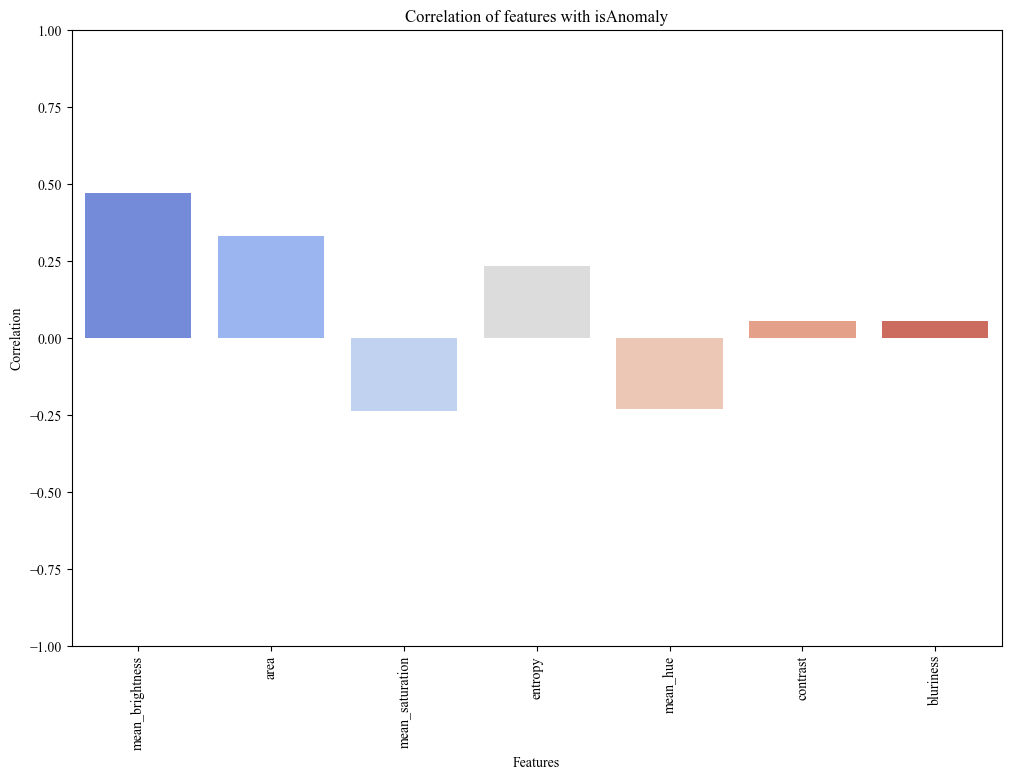

In [110]:
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df.index, y=correlation_df['Correlation_with_isAnomaly'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlation of features with isAnomaly')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.ylim(-1, 1)
plt.show()

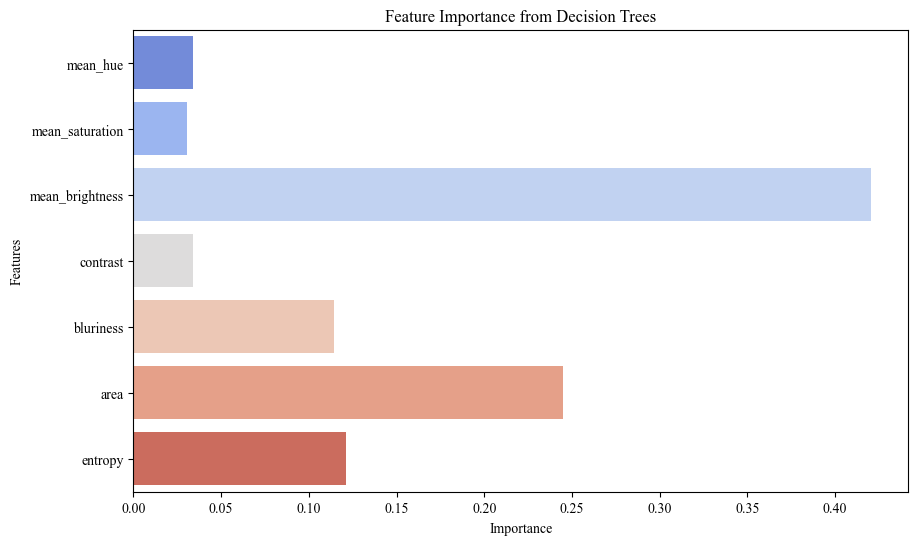

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifier = DecisionTreeClassifier()  # O RandomForestClassifier()
classifier.fit(imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1), imageFeatures_balanced['isAnomaly'])

feature_importance = classifier.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1).columns, palette='coolwarm')
plt.title('Feature Importance from Decision Trees')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

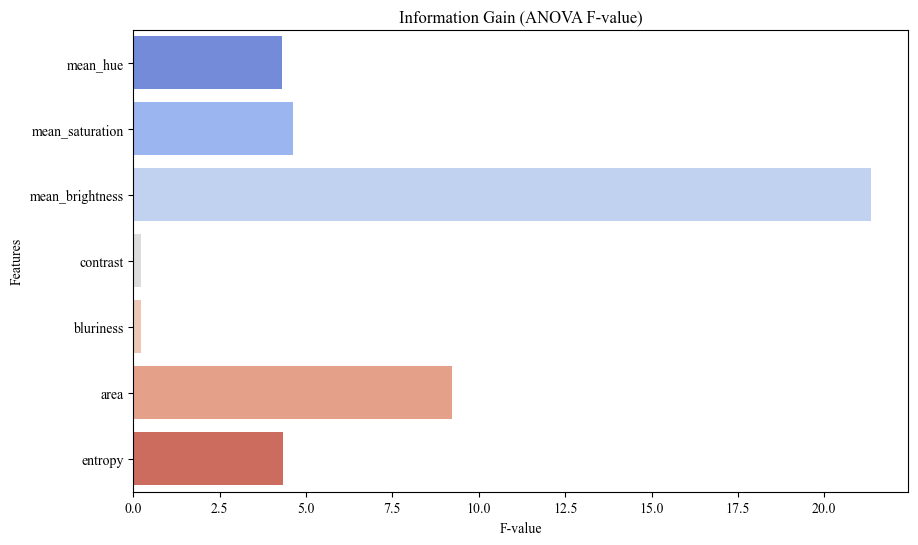

In [112]:
from sklearn.feature_selection import f_classif

f_values, _ = f_classif(imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1), imageFeatures_balanced['isAnomaly'])

plt.figure(figsize=(10, 6))
sns.barplot(x=f_values, y=imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1).columns, palette='coolwarm')
plt.title('Information Gain (ANOVA F-value)')
plt.xlabel('F-value')
plt.ylabel('Features')
plt.show()